In [1]:
import torch
import json
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from dataset_loaders import NYUV2DataSet, DA2KDataSet
from loss import eval_depth


from transformers import QuantoConfig
from transformers import HqqConfig
from transformers import AutoModelForDepthEstimation, AutoImageProcessor

quantization_config = QuantoConfig(weights="int4")
hqq_config = HqqConfig(nbits=4, group_size=64)

/home/adam-torek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
da_data = DA2KDataSet("datasets/DA-2K")

In [3]:
example_image = da_data.__getitem__(0)

In [4]:
nyuv2_data = NYUV2DataSet(dataset_path="datasets/NYUV2",csv_name="nyu2_test.csv")

In [5]:
nyuv2_data.__len__()

654

In [6]:
example_images = nyuv2_data.__getitem__(2)

In [7]:
example_images[1].shape

torch.Size([1, 518, 518])

In [8]:
depth_anything_checkpoint = "LiheYoung/depth-anything-small-hf"
depth_anything_processor = AutoImageProcessor.from_pretrained(depth_anything_checkpoint, quantization_config=hqq_config)
depth_anything_model = AutoModelForDepthEstimation.from_pretrained(depth_anything_checkpoint, quantization_config=hqq_config)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


### NYUV2 Data Testing

In [9]:
inputs = depth_anything_processor(images=example_images[0], return_tensors="pt")
with torch.no_grad():
    outputs = depth_anything_model(**inputs)
    predicted_depth = outputs.predicted_depth

In [10]:
np.swapaxes(example_images[0].squeeze().cpu().numpy(),2,0).shape

(518, 518, 3)

In [11]:
predicted_depth.dtype

torch.float32

In [14]:
example_images[1].dtype

torch.float32

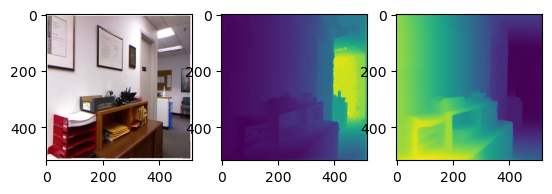

In [13]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(transforms.ToPILImage()(example_images[0]))
axarr[1].imshow(example_images[1].squeeze().cpu().numpy())
axarr[2].imshow(predicted_depth.squeeze().cpu().numpy())
plt.show()

In [16]:
eval_depth(predicted_depth, example_images[1])

{'d1': 0.0,
 'd2': 0.0,
 'd3': 0.0,
 'abs_rel': 0.9931967854499817,
 'sq_rel': 2395.364013671875,
 'rmse': 2896.209228515625,
 'rmse_log': inf,
 'log10': inf,
 'silog': nan}

### DA-2K Data Testing

In [ ]:
da_inputs = depth_anything_processor(images=example_image["image"], return_tensors="pt")
with torch.no_grad():
    da_outputs = depth_anything_model(**inputs)
    da_depth = outputs.predicted_depth

In [ ]:
da2_resizer = transforms.Resize(size=example_image["image"].size)

In [ ]:
point_1 = da_depth[example_image["points"][0][0], example_image["points"][0][1]].item()

In [ ]:
point_2 = da_depth[example_image["points"][1][0], example_image["points"][1][1]].item()

In [ ]:
print(point_1)
print(point_2)

In [ ]:
if example_image["closer_point"] == 0:
    if point_1 > point_2:
        print("Correct")
    else:
        print("Incorrect")
elif example_image["closer_point"] == 1:
    if point_2 > point_1:
        print("Correct")
    else:
        print("Incorrect")